## Competition Description

The objective of this competition is to predict 3 months of item-level sales data at different store locations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100) # 100 yerine None yazilabiliyormus

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

## EDA

### Data Exploration
###### Examining the dataset to understand its structure, size, and the types of variables it contains.

In [3]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
df_test.shape, df_train.shape

((45000, 4), (913000, 4))

In [6]:
df_test.info(), df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


(None, None)

In [7]:
df_test.describe(), df_train.describe()

(                 id         store         item
 count  45000.000000  45000.000000  45000.00000
 mean   22499.500000      5.500000     25.50000
 std    12990.525394      2.872313     14.43103
 min        0.000000      1.000000      1.00000
 25%    11249.750000      3.000000     13.00000
 50%    22499.500000      5.500000     25.50000
 75%    33749.250000      8.000000     38.00000
 max    44999.000000     10.000000     50.00000,
                store           item          sales
 count  913000.000000  913000.000000  913000.000000
 mean        5.500000      25.500000      52.250287
 std         2.872283      14.430878      28.801144
 min         1.000000       1.000000       0.000000
 25%         3.000000      13.000000      30.000000
 50%         5.500000      25.500000      47.000000
 75%         8.000000      38.000000      70.000000
 max        10.000000      50.000000     231.000000)

In [8]:
# merge two Dataframes into one, in this case we dont need to edit the columns for each Dataframe seperately

df = pd.concat([df_train, df_test], ignore_index = True)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [9]:
#to extract the month and year from the datetime object, and returns them as a tuple of (month, year)

from datetime import datetime, date
df['month'], df['year'] = zip(*df.date.apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').strftime('%m'), datetime.strptime(x, '%Y-%m-%d').strftime('%Y'))))

In [10]:
df['date'] = pd.to_datetime(df['date']) #type casting
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday
df = df.drop(['hour',"id"], axis = 1)

In [11]:
#to easier filt and select data based on the date, we set index to datetime

df= df.set_index('date')

### Data Visualization
#### Creating visual representations of the data to help identify patterns, trends, and outliers.

<AxesSubplot:xlabel='date'>

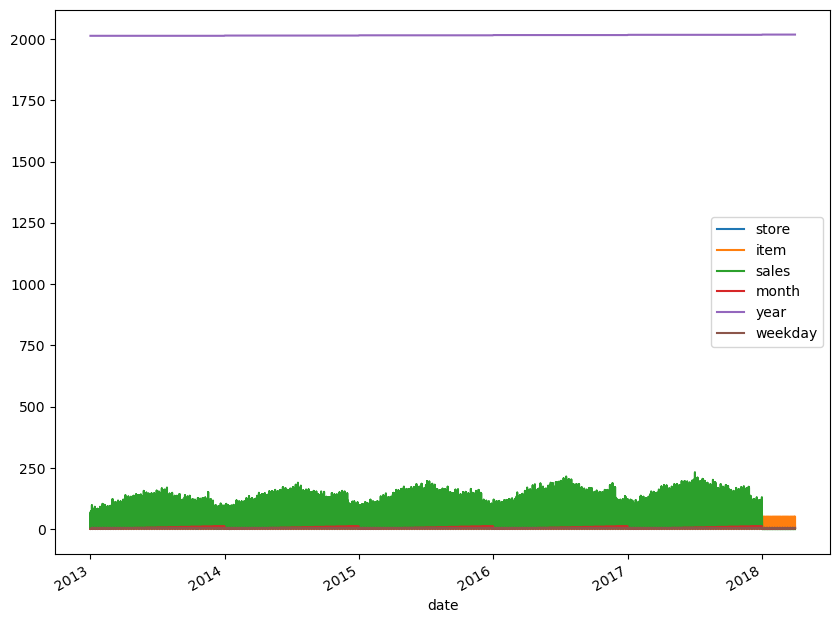

In [22]:
df.plot(figsize=(10, 8))

In [25]:
def total_sales_per_item(df):
    sales_by_store = df.groupby('item')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(20,8))
    sns.barplot(sales_by_store.item, sales_by_store.sales, order=sales_by_store.sort_values('sales', ascending = False).item)
    
    ax.set(xlabel = "Item Id", ylabel = "Sum of Sales", title = "Total Sales Per Item")
    plt.xticks(fontsize=12, rotation=90)
    
    return

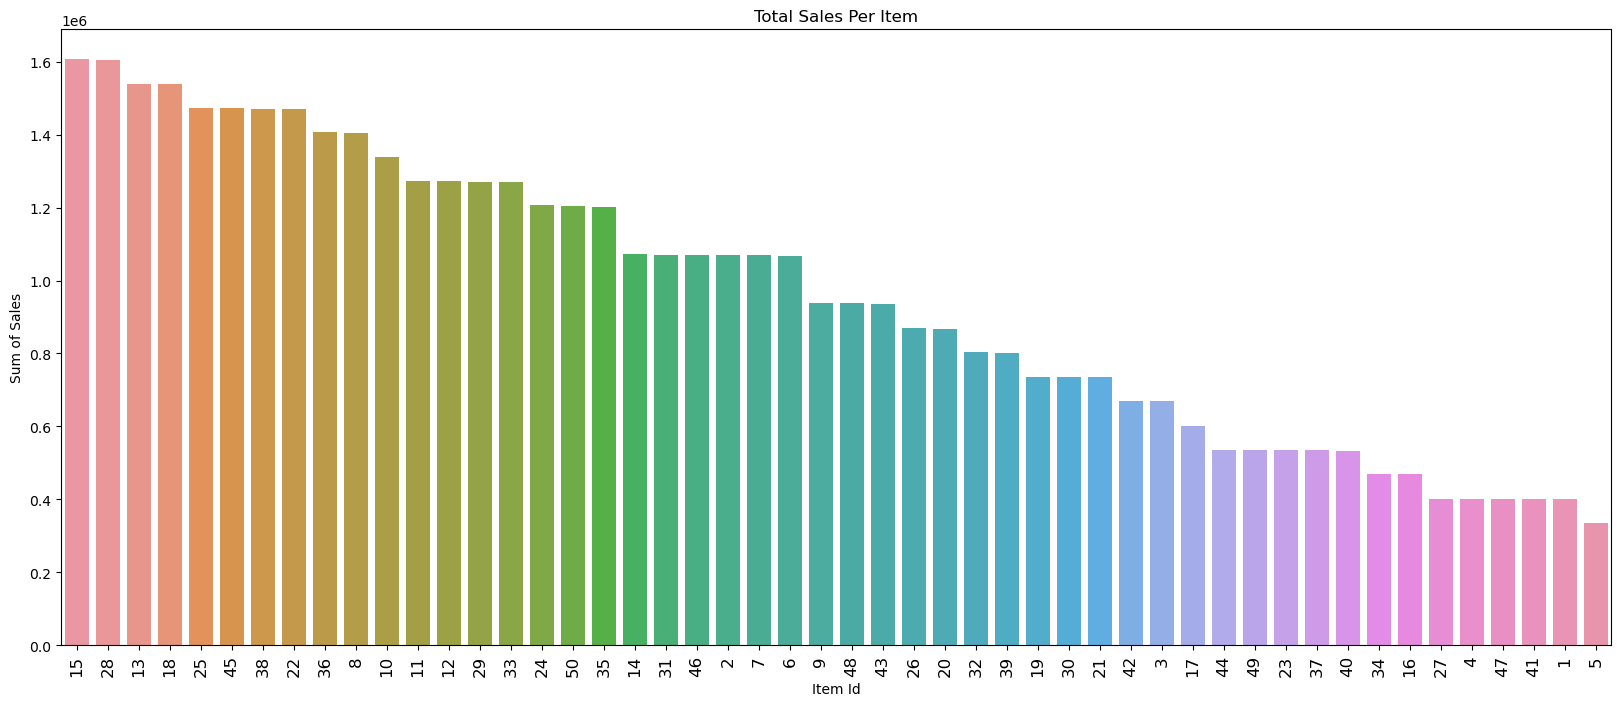

In [27]:
total_sales_per_item(df)

In [31]:
item_sales_per_store = df.groupby(['store', 'item'])['sales'].sum()
item_sales_per_store

store  item
1      1        36468.0
       2        97050.0
       3        60638.0
       4        36440.0
       5        30335.0
                 ...   
10     46      120601.0
       47       45204.0
       48      105570.0
       49       60317.0
       50      135192.0
Name: sales, Length: 500, dtype: float64

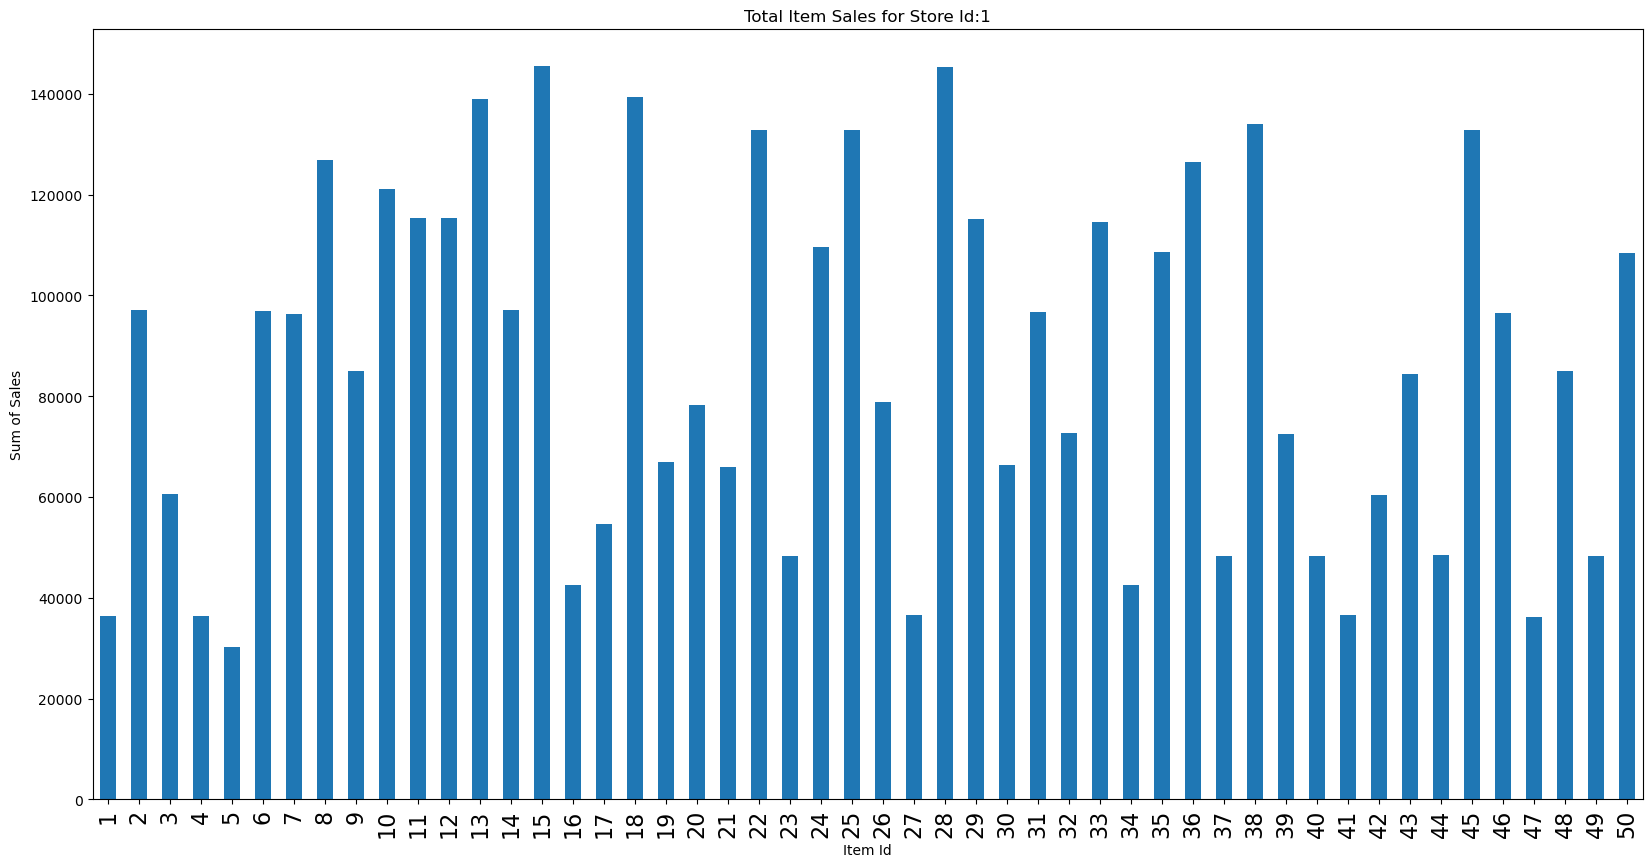

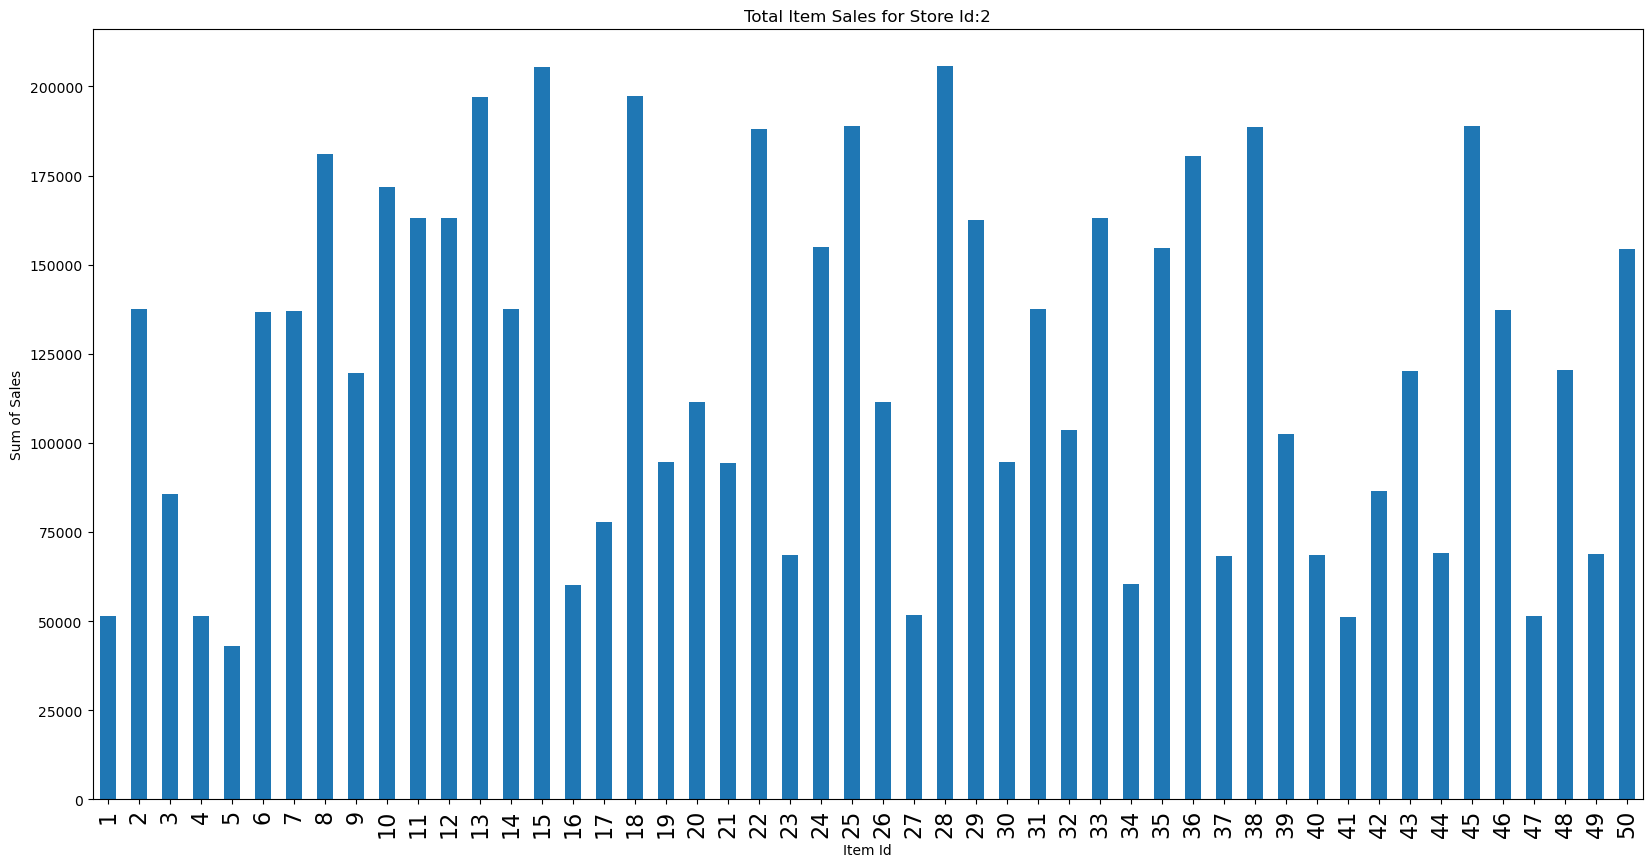

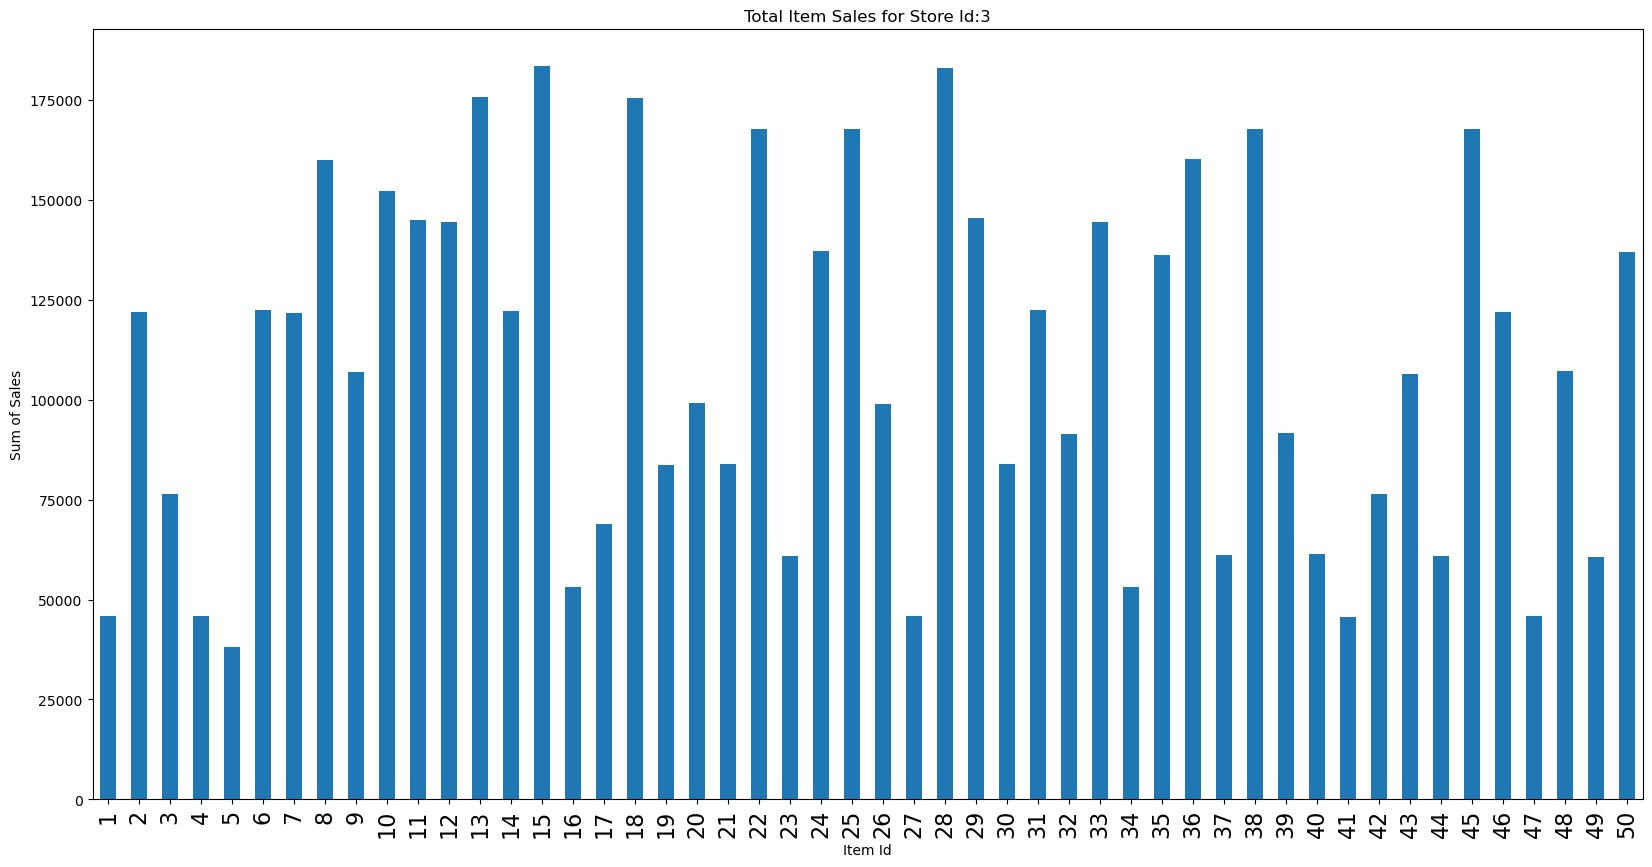

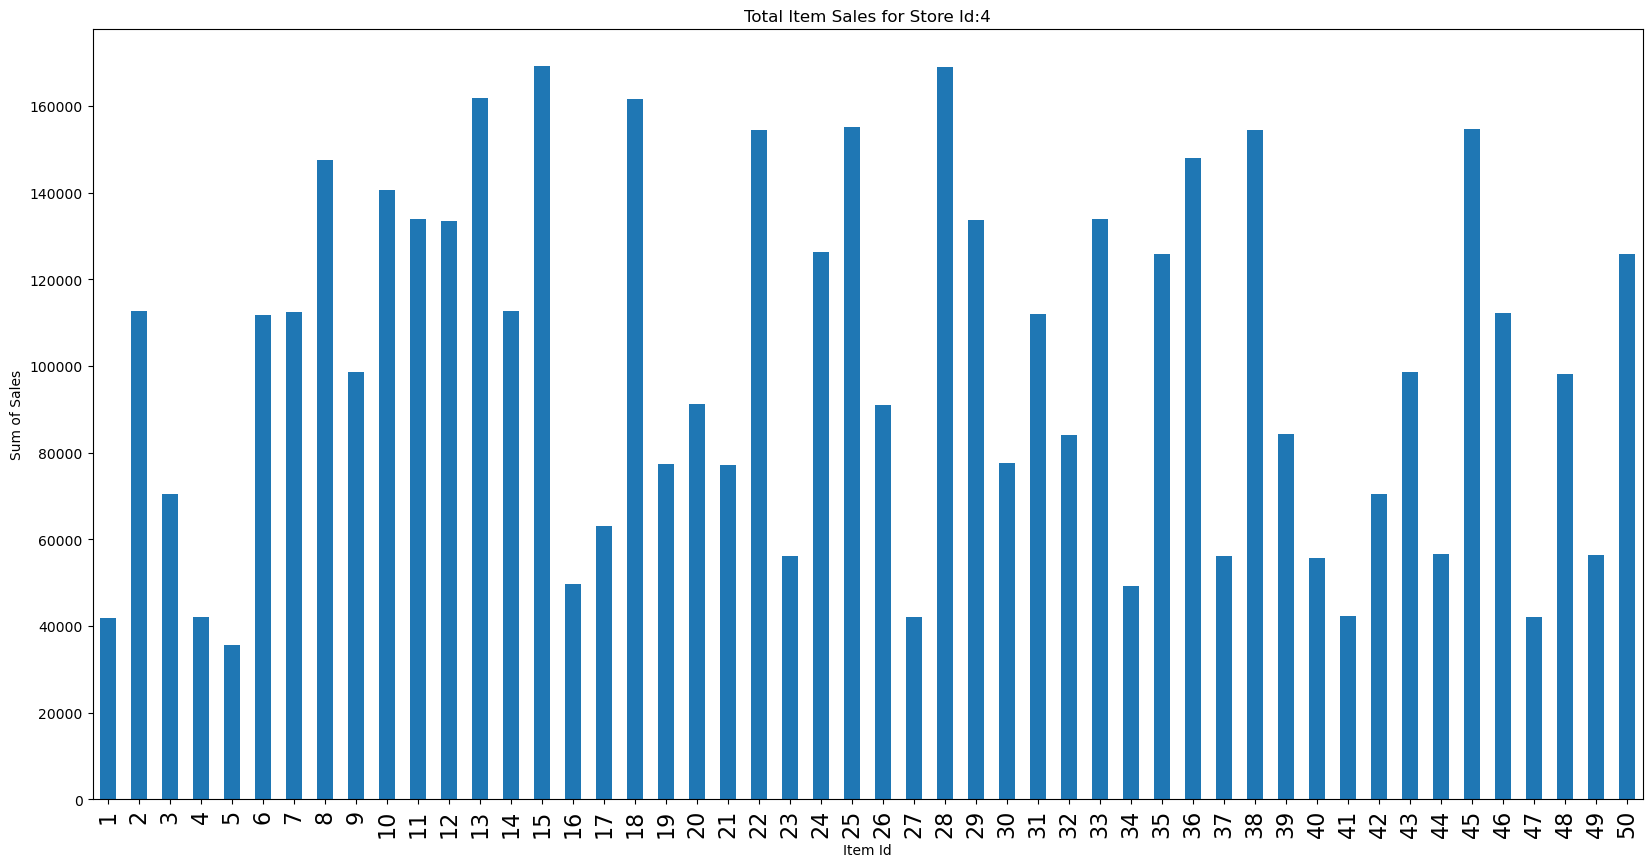

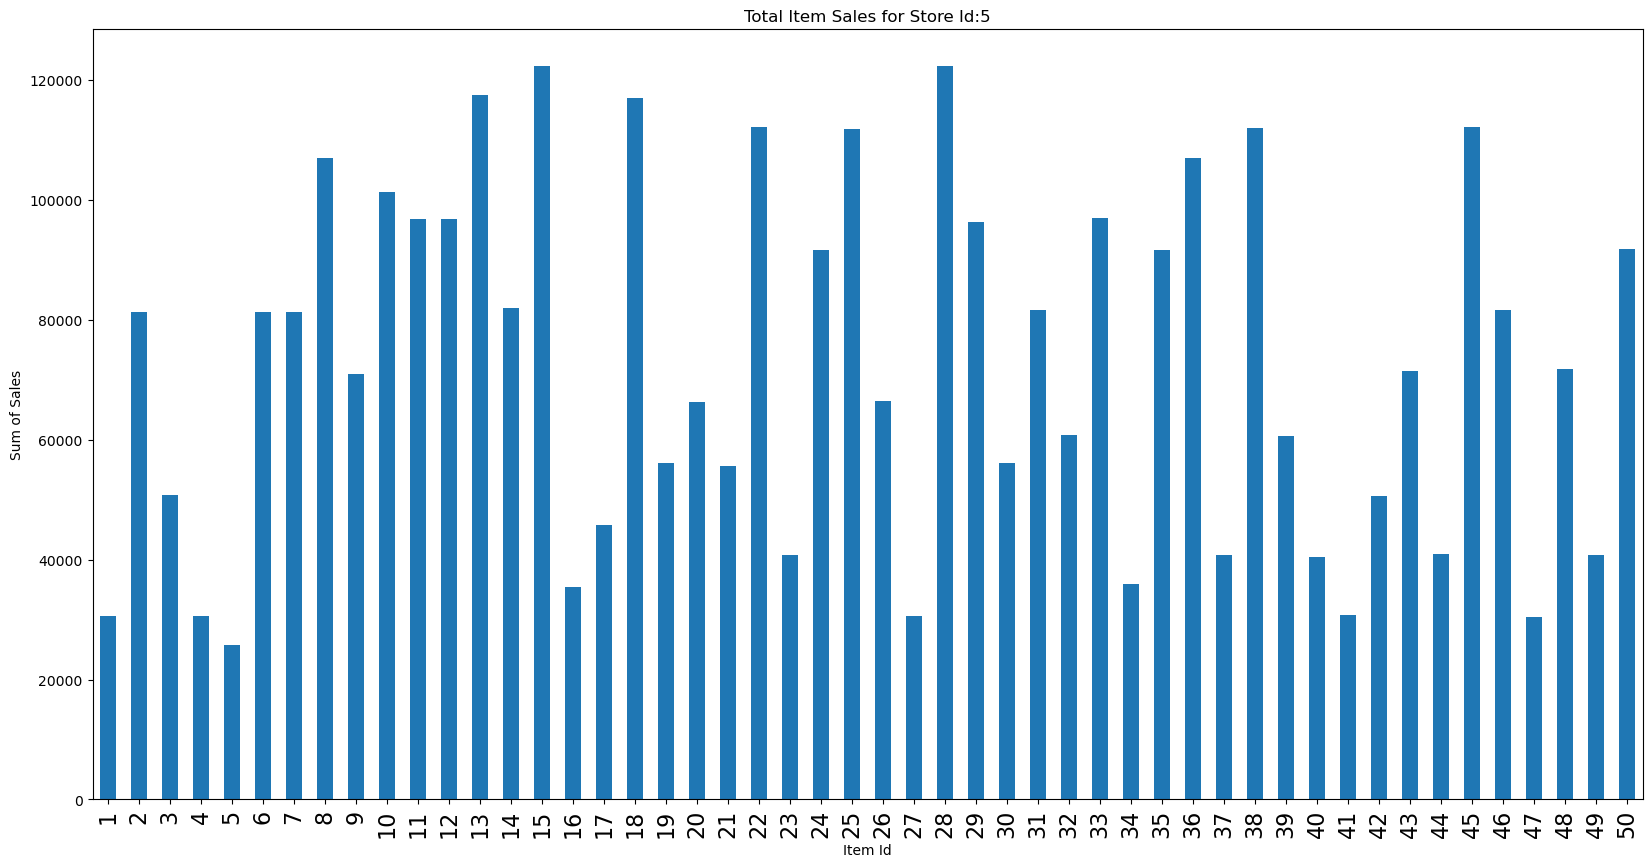

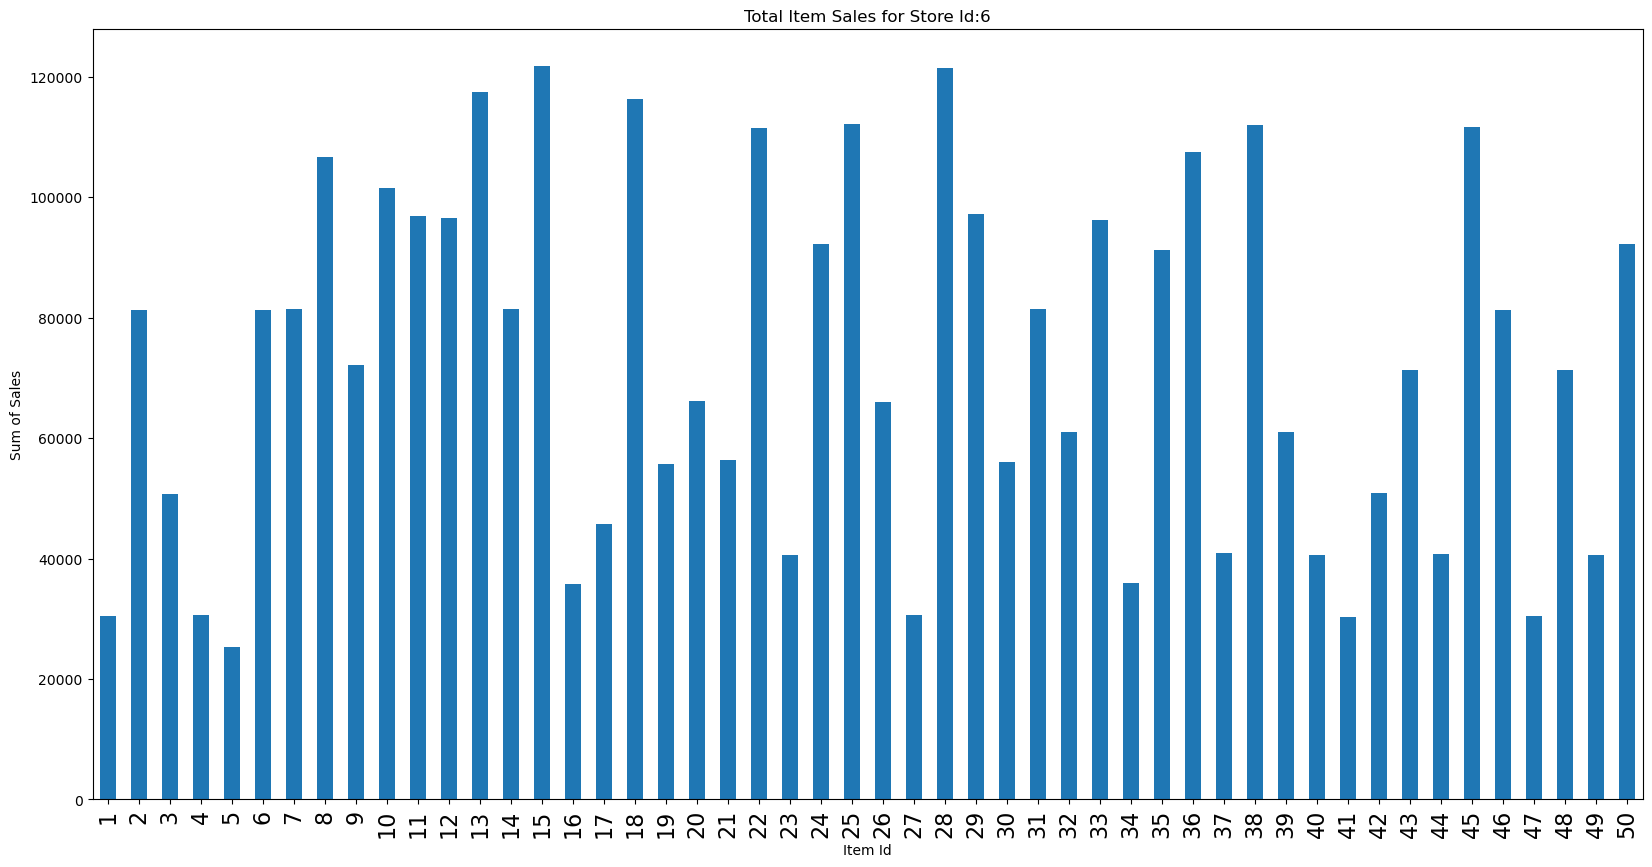

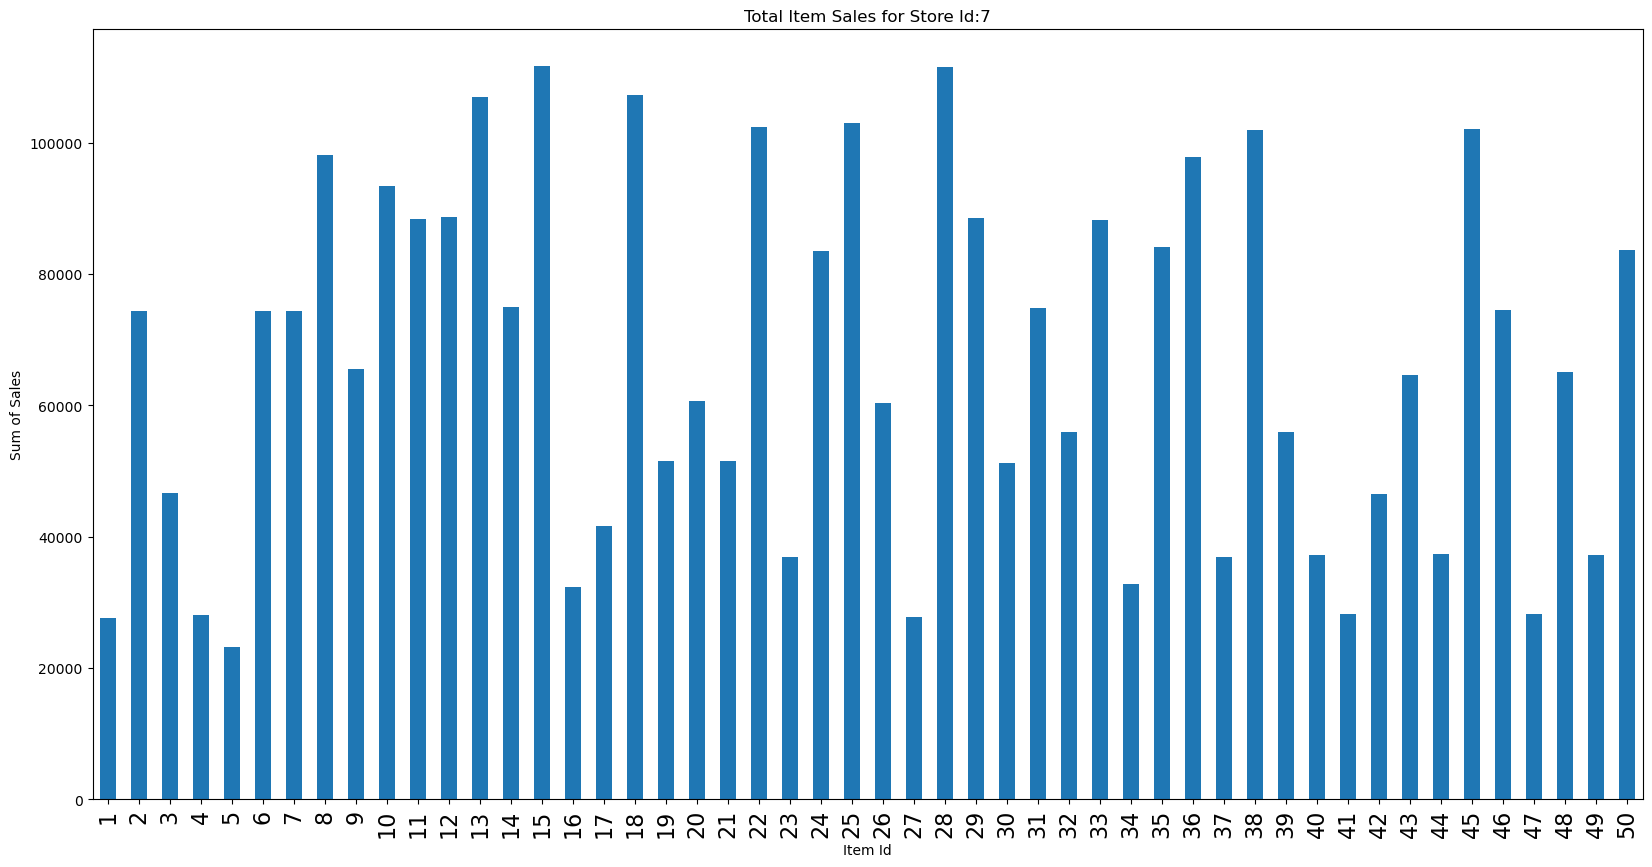

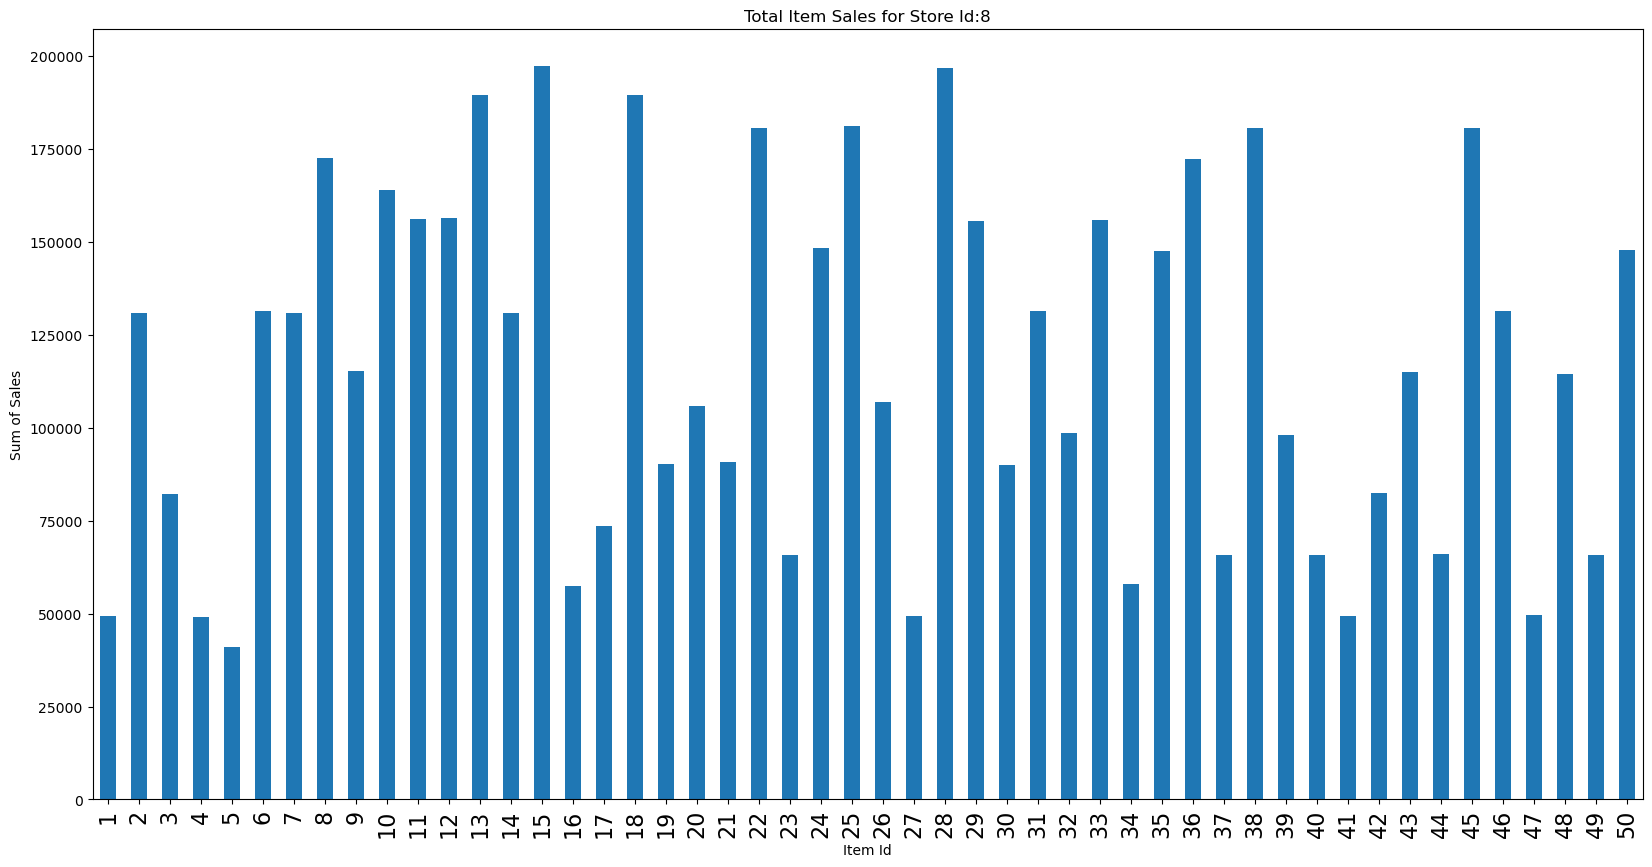

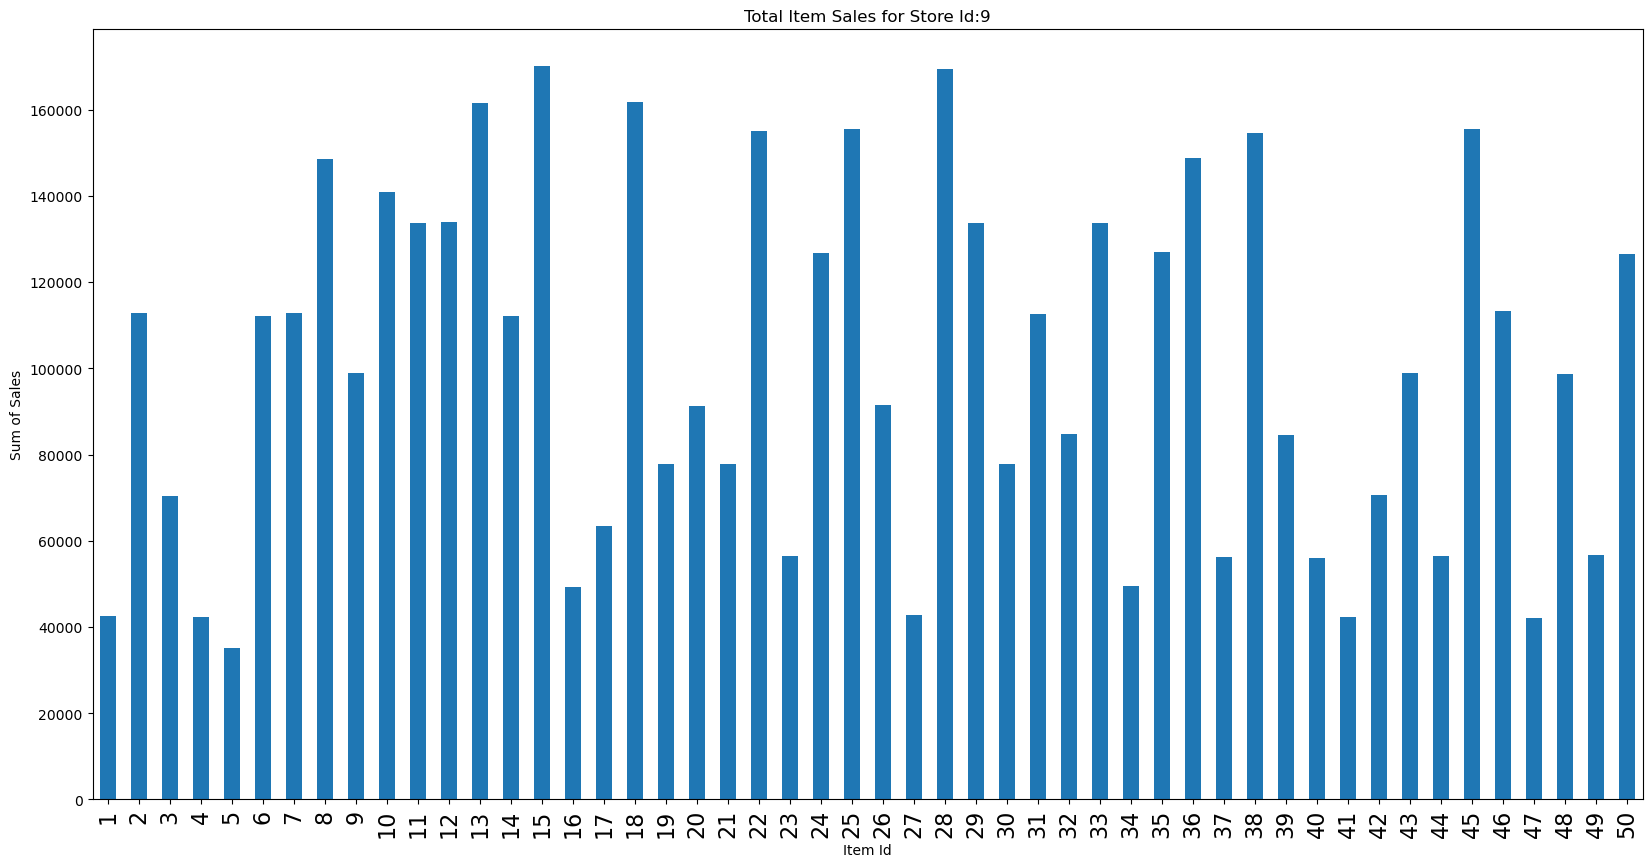

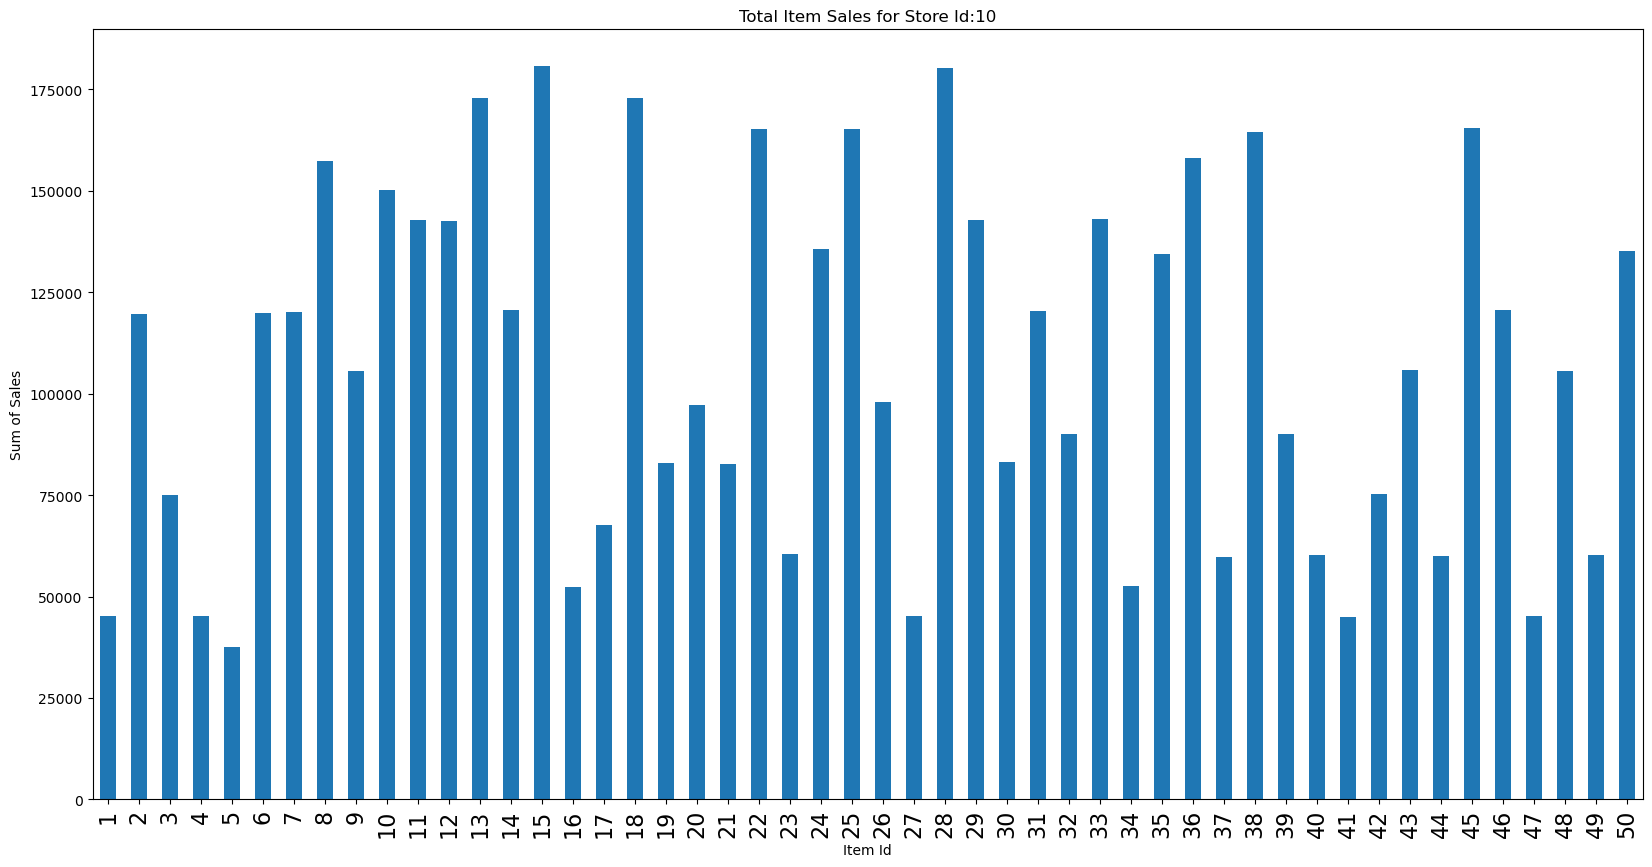

In [32]:
for i in df.store.unique():
    plt.figure(figsize=(20,10))
    item_sales_per_store.loc[i,:].plot(kind= "bar")
    plt.xlabel("Item Id"),
    plt.ylabel("Sum of Sales")
    plt.title("Total Item Sales for Store Id:{}".format(i))
    plt.xticks(fontsize=16, rotation=90)
    plt.show();

### Data preprocessing
###### Transforming the data to make it suitable for modeling. This can include normalizing, scaling, or encoding categorical variables.

In [12]:
X_train = df.iloc[:913000]
X_test = df.iloc[913000:]

In [13]:
X_train['sales'] = X_train['sales'].astype(np.int64)

In [14]:
X_test.fillna(0,inplace=True)

In [15]:
X_train.shape, X_test.shape

((913000, 6), (45000, 6))

In [16]:
X_train = X_train.drop(['sales'], axis = 1)
X_test = X_test.drop(['sales'], axis = 1)

In [17]:
y = df_train['sales']

### Data modeling
###### Creating models to make predictions or classify the data.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [19]:
def algo_test(x,y):
        L=LinearRegression()
        R=Ridge()
        Lass=Lasso()
        E=ElasticNet()
        ETR=ExtraTreeRegressor()
        GBR=GradientBoostingRegressor()
        kn=KNeighborsRegressor()
        dt=DecisionTreeRegressor()
        xgb=XGBRegressor()
        
        algos=[L,R,Lass,E,ETR,GBR,kn,dt,xgb]
        algo_names=['Linear','Ridge','Lasso','ElasticNet','Extra Tree','Gradient Boosting','KNeighborsRegressor','Decision Tree','XGBRegressor']
        
        x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2,random_state=42)
        
        r_squared= []
        rmse= []
        mae= []
        
        result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
        
        for algo in algos:
            p=algo.fit(x_train,y_train).predict(x_test)
            r_squared.append(r2_score(y_test,p))
            rmse.append(mean_squared_error(y_test,p)**.5)
            mae.append(mean_absolute_error(y_test,p))
        
        result.R_Squared=r_squared
        result.RMSE=rmse
        result.MAE=mae
        
        rtable=result.sort_values('R_Squared',ascending=False)
        return rtable

In [20]:
algo_test(X_train, y)

,R_Squared,RMSE,MAE
XGBRegressor,0.929398,7.646726,5.904521
Decision Tree,0.910925,8.589024,6.602579
Extra Tree,0.908620,8.699475,6.637773
KNeighborsRegressor,0.888173,9.623675,7.255371
Gradient Boosting,0.692369,15.961789,12.170702
Linear,0.094319,27.387618,22.082344
Ridge,0.094319,27.387618,22.082344
Lasso,0.093153,27.405239,22.100347
ElasticNet,0.090900,27.439270,22.124316
